In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np


Using TensorFlow backend.


In [0]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss( y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


def wasserstein_loss(y_true, y_pred):
        return K.mean(y_true * y_pred)

In [0]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows,img_cols, channels)
latent_dim = 100

        
n_critic = 5
optimizer = RMSprop(lr=0.00005)


In [0]:
model = Sequential()
noise = Input(shape=(latent_dim,))
O=Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim)(noise)
O=Reshape((7, 7, 128))(O)
O=UpSampling2D()(O)
O=Conv2D(128, kernel_size=4, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=Activation("relu")(O)
O=UpSampling2D()(O)
O=Conv2D(64, kernel_size=4, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=Activation("relu")(O)
O=Conv2D(channels, kernel_size=4, padding="same")(O)
img=Activation("tanh")(O)


generator=Model(inputs=[noise], outputs=[img])

In [0]:
img = Input(shape=img_shape)

O=Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding="same")(img)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Conv2D(32, kernel_size=3, strides=2, padding="same")(O)
O=ZeroPadding2D(padding=((0,1),(0,1)))(O)
O=BatchNormalization(momentum=0.8)(O)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Conv2D(64, kernel_size=3, strides=2, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Conv2D(128, kernel_size=3, strides=1, padding="same")(O)
O=BatchNormalization(momentum=0.8)(O)
O=LeakyReLU(alpha=0.2)(O)
O=Dropout(0.25)(O)
O=Flatten()(O)
validity=Dense(1)(O)


critic = Model(inputs=[img], outputs=[validity])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
generator.trainable = False
real_img = Input(shape=img_shape)
# Noise input
z_disc = Input(shape=(latent_dim,))

# Generate image based of noise (fake sample)
fake_img = generator(z_disc)

fake = critic(fake_img)
valid = critic(real_img)

# Construct weighted average between real and fake images
interpolated_img = RandomWeightedAverage()([real_img, fake_img])
 # Determine validity of weighted sample
validity_interpolated = critic(interpolated_img)

In [0]:
partial_gp_loss = partial(gradient_penalty_loss,averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

critic_model = Model(inputs=[real_img, z_disc],outputs=[valid, fake, validity_interpolated])
critic_model.compile(loss=[wasserstein_loss,wasserstein_loss,partial_gp_loss],optimizer=optimizer,loss_weights=[1, 1, 10])

In [0]:
#-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
critic.trainable = False
generator.trainable = True

# Sampled noise for input to generator
z_gen = Input(shape=(latent_dim,))
# Generate images based of noise
img = generator(z_gen)
# Discriminator determines validity
valid = critic(img)
# Defines generator model
generator_model = Model(z_gen, valid)
generator_model.compile(loss=wasserstein_loss, optimizer=optimizer)

In [0]:
def sample_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()

In [0]:
import os
os.mkdir("images")

In [0]:
os.mkdir("weights")

In [0]:
epochs=30000
batch_size=32
sample_interval=100
# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

        # Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

# Adversarial ground truths
valid = -np.ones((batch_size, 1))
fake =  np.ones((batch_size, 1))
dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
for epoch in range(epochs):

            for _ in range(n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, latent_dim))
                # Train the critic
                d_loss = critic_model.train_on_batch([imgs, noise],[valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = generator_model.train_on_batch(noise, valid)

            # Plot the progress
            

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
                sample_images(epoch)
critic_model.save_weights('weights/critic_model.h5')
generator_model.save_weights('weights/generator_model.h5')


11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 5.424684] [G loss: 0.588975]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: -0.411085] [G loss: -1.898563]
200 [D loss: -0.553805] [G loss: -2.436589]
300 [D loss: -0.399898] [G loss: -2.698101]
400 [D loss: -0.857405] [G loss: -2.799584]
500 [D loss: -0.312946] [G loss: -2.758680]
600 [D loss: -0.898423] [G loss: -2.258036]
700 [D loss: -0.243636] [G loss: -2.060264]
800 [D loss: -1.134558] [G loss: -2.072329]
900 [D loss: -1.084150] [G loss: -2.253939]
1000 [D loss: -0.925627] [G loss: -1.613780]
1100 [D loss: -1.304686] [G loss: -1.538786]
1200 [D loss: -0.137141] [G loss: -1.365250]
1300 [D loss: -0.299227] [G loss: -2.128389]
1400 [D loss: -1.248217] [G loss: -1.562972]
1500 [D loss: -1.080565] [G loss: -1.306919]
1600 [D loss: -0.896772] [G loss: -0.544719]
1700 [D loss: -0.555178] [G loss: -0.462584]
1800 [D loss: -0.094248] [G loss: -0.159923]
1900 [D loss: 0.169333] [G loss: 0.137790]
2000 [D loss: 0.284056] [G loss: 0.428383]
2100 [D loss: -0.512163] [G loss: 0.128737]
2200 [D loss: -1.449814] [G loss: -0.059801]
2300 [D loss: -0.108114]

In [0]:
### generate images
def generate(BATCH_SIZE): 
    noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
    generated_images =generator.predict(noise)
    return generated_images

### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(y_true - y_pred))

### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    
    intermidiate_model = Model(inputs=critic.layers[0].input, outputs=critic.layers[2].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

### anomaly detection model define
def anomaly_detector(g=None, d=None):
    
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    g = Model(inputs=generator.layers[1].input, outputs=generator.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(100,))
    gInput = Dense((100), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model

### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None):
    z = np.random.normal(0, 1, size=(1, 100))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

## combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

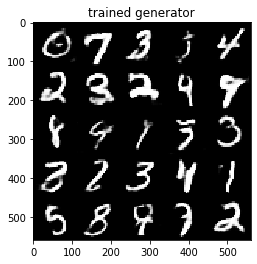

In [0]:
import math
import cv2
generated_img = generate(25)
img = combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)



plt.figure(num=0, figsize=(4, 4))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()



In [0]:
def anomaly_detection(test_img, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img =compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(28,28,1) - similar_img.reshape(28,28,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(28,28,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_test_original = X_test.copy()

X_train = X_train[y_train==1]
X_test = X_test[y_test==1]

9 label, 16 : done 25.76 2785.26ms
anomaly score :  25.76205825805664


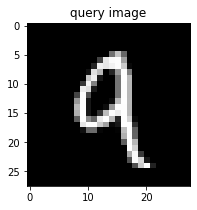

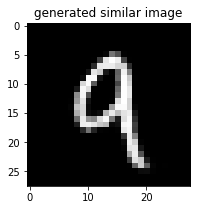

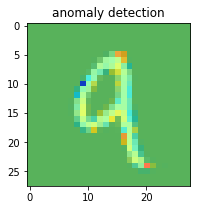

In [0]:
img_idx = 16
label_idx = 9
test_img = X_test_original[y_test==label_idx][img_idx]

start = cv2.getTickCount()
score, qurey, pred, diff = anomaly_detection(test_img)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
print ('%d label, %d : done'%(label_idx, img_idx), '%.2f'%score, '%.2fms'%time)

plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(qurey.reshape(28,28), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(28,28), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
from sklearn.manifold import TSNE
import random
model = feature_extractor()
idx=np.arange(len(X_test_original))
random.shuffle(idx)

feature_map_of_minist = model.predict(X_test_original[idx[0:2000]], verbose=1)
output = feature_map_of_minist.reshape(feature_map_of_minist.shape[0], -1)



2000/2000 [==============================] - 0s 165us/step


In [0]:
X_embedded = TSNE(n_components=2).fit_transform(output)

In [0]:
labels.shape

(10000,)

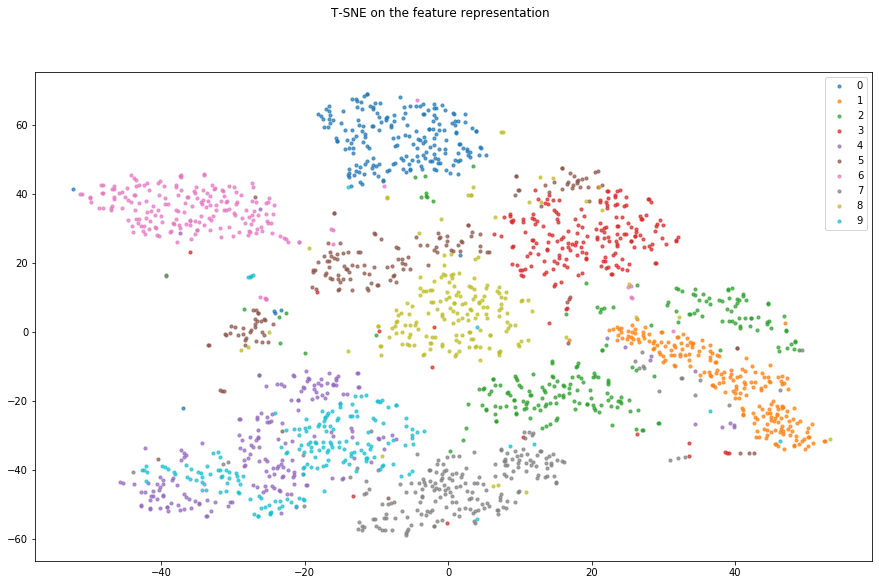

In [0]:
embeddings_test_2d = X_embedded

labels=y_test[idx[0:2000]]
import matplotlib.pyplot as plt
unique_labels = np.unique(labels)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6','C7','C8','C9']

fig, ax = plt.subplots()
for i in range(len(unique_labels)):
    idxs = [j for j in range(len(labels)) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE on the feature representation',fontsize=12)
fig.set_size_inches(15,9)
plt.show()